## Data & EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#loading the stopwords library and the nltk to be used for the text preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')

train_data = pd.concat([train_data, test_data], axis=0)
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
train_data.shape

(215063, 7)

In [6]:
train_data['condition'].value_counts()

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: count, Length: 916, dtype: int64

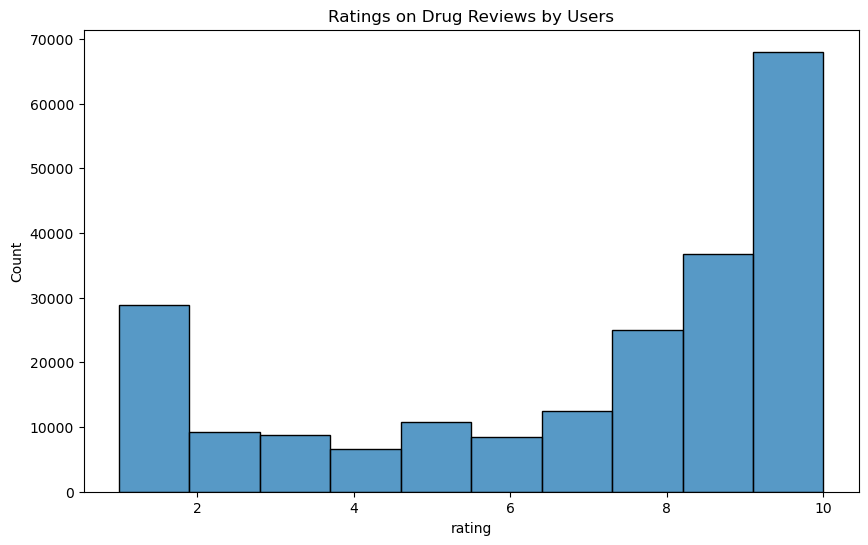

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Ratings on Drug Reviews by Users')
plt.savefig('histogram_of_ratings.png')
plt.show()

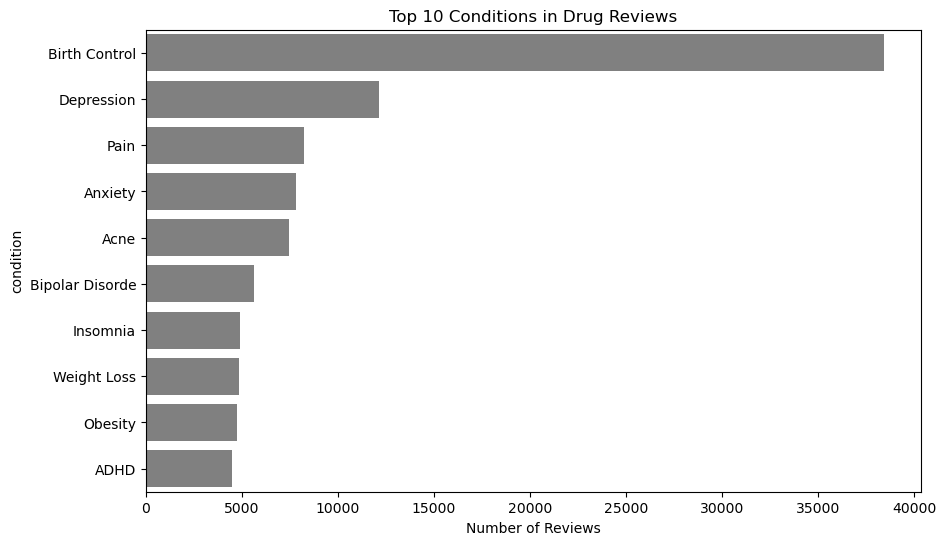

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 10 most frequent conditions in the dataset
plt.figure(figsize=(10, 6))
top_10_conditions = train_data['condition'].value_counts().head(10)
sns.barplot(x=top_10_conditions.values, y=top_10_conditions.index, color='grey')
plt.title('Top 10 Conditions in Drug Reviews')
plt.xlabel('Number of Reviews')
plt.savefig('Top_10_conditions.png')
plt.show()


In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re



def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens) #--- Joins the token into a simple word. 

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data['processed_review'].head()

0           side effect take combin bystol mg fish oil
1    son halfway fourth week intuniv becam concern ...
2    use take anoth oral contracept pill cycl happi...
3    first time use form birth control im glad went...
4    suboxon complet turn life around feel healthie...
Name: processed_review, dtype: object

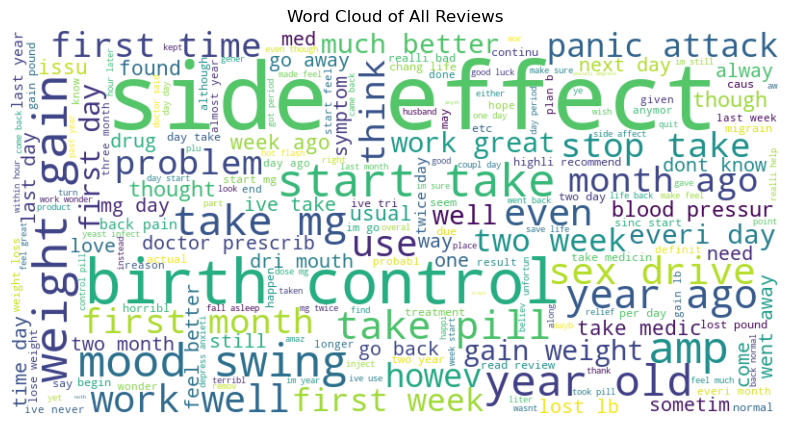

In [10]:
#creating a word cloud to visualize the most used words in 215,063 drug reviews by the users
from wordcloud import WordCloud

all_words = ' '.join(train_data['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Word Cloud of All Reviews')

plt.savefig('wordcloud.png')
plt.show()

## Text Processing and Feature Engineering

#### TF-IDF

In [11]:
#---------TF-IDF -----------#
from sklearn.feature_extraction.text import TfidfVectorizer

#Now in this stage we want to assign importance to words in the training data by using the TF IDF method which 
#can help distinguish words in accordance to how they are most used for ratings

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_data['processed_review'])


### Word2Vec

In [12]:
import gensim

# Training a Word2Vec model tokenized reviews using the SkipGram method
word2vec_model = gensim.models.Word2Vec(sentences=train_data['processed_review'], vector_size=300, window=5, min_count=2, sg=1, workers=4)


def get_average_word2vec(tokens_list, model, vector_size):
    
    valid_words = [word for word in tokens_list if word in model.wv.key_to_index] #vocabulary from word2Vec model
    
    if not valid_words: 
        return np.zeros(vector_size) #we want to return a zero vector for the doc in case no valid words are found in the doc
    
    return np.mean(model.wv[valid_words], axis=0) # the entire review is converted into a single vector, 
                                                  #instead of different vectors for each word in the document

vector_size = word2vec_model.vector_size
train_data['word2vec_review'] = train_data['processed_review'].apply(lambda x: get_average_word2vec(x, word2vec_model, vector_size))


X_word2vec = np.vstack(train_data['word2vec_review'].values) # To convert the into a numpy array


### Encoding Ratings to Sentiments

In [13]:
def categorize_sentiment(rating):
    if rating <= 4:
        return 0  # Negative
    elif rating <= 7:
        return 1  # Neutral
    else:
        return 2  # Positive
    
train_data['sentiment'] = train_data['rating'].apply(categorize_sentiment)
y = train_data['sentiment']

##### Trein-Test Split for TF_IDF and Word2Vec Models

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

Xtf_train, Xtf_test, ytf_train, ytf_test = train_test_split(X_tfidf, y, test_size=0.15, random_state = 1)
Xw2v_train, Xw2v_test, yw2v_train, yw2v_test = train_test_split(X_word2vec, y, test_size=0.15, random_state = 1)

scaler = MaxAbsScaler()
Xtf_train_scaled = scaler.fit_transform(Xtf_train)
Xtf_test_scaled = scaler.transform(Xtf_test)



In [29]:
scaler2 = StandardScaler()
Xw2v_train_scaled = scaler2.fit_transform(Xw2v_train)
Xw2v_test_scaled = scaler2.transform(Xw2v_test)

In [31]:
Xw2v_train_scaled.shape


(182803, 300)

## Model Training and Evaluation

#### TFIDF - evaluating the XGBoost, Random Forest and Logistic

In [16]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(Xtf_train_scaled)
X_test_svd = svd.transform(Xtf_test_scaled)

In [17]:

from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report




xgb_classifier = XGBClassifier(n_estimators=100, subsample = 0.88,
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_svd, ytf_train)
xgb_pred = xgb_classifier.predict(X_test_svd)

print("\XGBoost Classifier Results:")
print(classification_report(ytf_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))

\XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.56      0.20      0.29      8002
     Neutral       0.58      0.01      0.02      4720
    Positive       0.64      0.96      0.77     19538

    accuracy                           0.63     32260
   macro avg       0.59      0.39      0.36     32260
weighted avg       0.61      0.63      0.54     32260



In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5,
                                           n_jobs=-1, random_state=42)
rf_classifier.fit(X_train_svd, ytf_train)
rf_pred = rf_classifier.predict(X_test_svd)

print("\nRandom Forest Classifier Results:")
print(classification_report(ytf_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))


Random Forest Classifier Results:
              precision    recall  f1-score   support

    Negative       0.55      0.02      0.03      8002
     Neutral       1.00      0.00      0.00      4720
    Positive       0.61      1.00      0.76     19538

    accuracy                           0.61     32260
   macro avg       0.72      0.34      0.26     32260
weighted avg       0.65      0.61      0.47     32260



In [19]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logistic_classifier.fit(X_train_svd, ytf_train)
logistic_pred = logistic_classifier.predict(X_test_svd)

print("\nLogistic Regression Results:")
print(classification_report(ytf_test, logistic_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))


Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.32      0.03      0.05      8002
     Neutral       0.67      0.00      0.00      4720
    Positive       0.61      0.98      0.75     19538

    accuracy                           0.60     32260
   macro avg       0.53      0.34      0.27     32260
weighted avg       0.55      0.60      0.47     32260



Without wasting compute time with max_depth, it appears the overall accurcay is around 62% when XGBoost and RandomForest are used for the classification. We will now proceed to use the optimal number of principal components to see if the accurcay improves. After several iterations it appears the XGBoost performs better than the Random Forest Classifier. 

Also, we notice here that there are class imbalances and there we need to adjust the data to ensure there is some balance.

 ### Word2Vec - Evaluating the Logistic, Random Forest and XGBoost Model 

In [20]:
pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(Xw2v_train_scaled)
X_test_pca = pca.transform(Xw2v_test_scaled)

xgb_classifier = XGBClassifier(n_estimators=100, subsample = 0.88,
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(Xw2v_train_scaled, yw2v_train)
xgb_pred = xgb_classifier.predict(Xw2v_test_scaled)

print("\XGBoost Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))



\XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.59      0.13      0.21      8002
     Neutral       1.00      0.00      0.01      4720
    Positive       0.63      0.98      0.76     19538

    accuracy                           0.62     32260
   macro avg       0.74      0.37      0.33     32260
weighted avg       0.67      0.62      0.52     32260



In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5,
                                           n_jobs=-1, random_state=42)
rf_classifier.fit(Xw2v_train_scaled, yw2v_train)
rf_pred = rf_classifier.predict(Xw2v_test_scaled)

print("\nRandom Forest Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))


Random Forest Classifier Results:
              precision    recall  f1-score   support

    Negative       0.59      0.13      0.21      8002
     Neutral       1.00      0.00      0.01      4720
    Positive       0.63      0.98      0.76     19538

    accuracy                           0.62     32260
   macro avg       0.74      0.37      0.33     32260
weighted avg       0.67      0.62      0.52     32260



In [22]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(multi_class='multinomial', solver='saga', random_state=42, max_iter=500)
logistic_classifier.fit(Xw2v_train_scaled, yw2v_train)
logistic_pred = logistic_classifier.predict(Xw2v_test_scaled)

print("\nLogistic Regression Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))


Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.59      0.13      0.21      8002
     Neutral       1.00      0.00      0.01      4720
    Positive       0.63      0.98      0.76     19538

    accuracy                           0.62     32260
   macro avg       0.74      0.37      0.33     32260
weighted avg       0.67      0.62      0.52     32260



### Reducing Features with PCA assuming Linearity

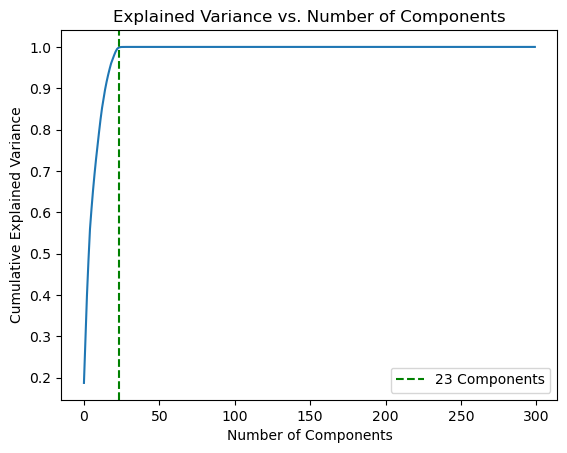

<Figure size 640x480 with 0 Axes>

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA on scaled training data
pca = PCA().fit(Xw2v_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')

# Find the number of components that explain 99% of the variance
num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

# Add a vertical line at the point where 99% variance is explained
plt.axvline(x=num_components_99, color='g', linestyle='--', label=f'{num_components_99} Components')
plt.legend()
plt.show()

# Save the plot
plt.savefig('PCA_feature_selection.png')

# Fit PCA with the number of components that explain 99% variance, only on the training data
pca = PCA(n_components=num_components_99)
X_train_reduced = pca.fit_transform(Xw2v_train_scaled)

# Apply the same PCA transformation on the test data
X_test_reduced = pca.transform(Xw2v_test_scaled)



### Reducing features with PCA Assuming Non-linearity

In [1]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import numpy as np

# Apply Kernel PCA with an RBF (Radial Basis Function) kernel
kpca = KernelPCA(kernel='rbf', fit_inverse_transform=True, n_components=Xw2v_train_scaled.shape[1])

# Fit Kernel PCA on the scaled training data
X_kpca_train = kpca.fit_transform(Xw2v_train_scaled)

# Compute explained variance using eigenvalues of the Kernel PCA
lambdas = kpca.lambdas_
explained_variance_ratio = lambdas / np.sum(lambdas)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')

# Find the number of components that explain 99% of the variance
num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

# Add a vertical line at the point where 99% variance is explained
plt.axvline(x=num_components_99, color='g', linestyle='--', label=f'{num_components_99} Components')

# Show the plot
plt.legend()
plt.show()

# Save the plot
plt.savefig('KernelPCA_feature_selection.png')

# Apply Kernel PCA with n_components that explains 99% of the variance
kpca = KernelPCA(kernel='rbf', n_components=num_components_99)

# Transform both training and test data
X_train_reduced = kpca.fit_transform(Xw2v_train_scaled)
X_test_reduced = kpca.transform(Xw2v_test_scaled)


NameError: name 'Xw2v_train_scaled' is not defined

### Dealing with the class imbalances

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, yw2v_train)

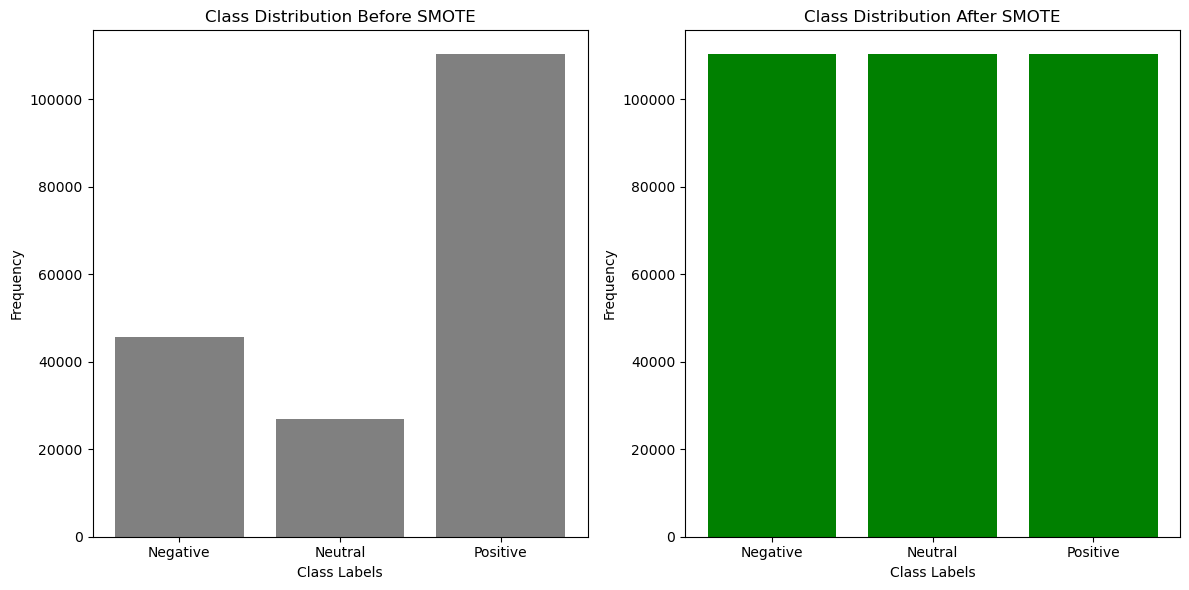

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(y_data, title, subplot, color, class_labels):
    unique, counts = np.unique(y_data, return_counts=True)
    plt.subplot(1, 2, subplot)
    plt.bar(unique, counts, color=color)
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(unique, class_labels)  # Setting the custom class labels

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(12, 6))

plot_class_distribution(yw2v_train, 'Class Distribution Before SMOTE', 1, 'grey', class_labels)

plot_class_distribution(y_train_balanced, 'Class Distribution After SMOTE', 2, 'green', class_labels)

plt.tight_layout()
plt.savefig('Smote_Balance_Classes.png')
plt.show()



### Using the Principal components with the highest explained variance on the balanced data for modeling

In [37]:
X_test_reduced.shape

(32260, 23)

## Tuning Parameters of the best XGB model

best model so far

xgb_classifier = XGBClassifier(n_estimators= 100, subsample = 0.7, max_depth = 30, max_delta_step = 2, 
                               learning_rate=0.5, reg_lambda= 5, reg_alpha = 2, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_reduced, yw2v_train)
xgb_pred = xgb_classifier.predict(X_test_reduced)

print("\nXGBoost Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))

In [68]:
xgb_classifier = XGBClassifier(n_estimators= 100, subsample = 0.7, max_depth = 30, max_delta_step = 2, 
                               learning_rate=0.5, reg_lambda= 5, reg_alpha = 2, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_reduced, yw2v_train)
xgb_pred = xgb_classifier.predict(X_test_reduced)

print("\nXGBoost Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))


XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.91      0.73      0.81      8002
     Neutral       0.97      0.70      0.81      4720
    Positive       0.85      0.97      0.91     19538

    accuracy                           0.87     32260
   macro avg       0.91      0.80      0.84     32260
weighted avg       0.88      0.87      0.87     32260



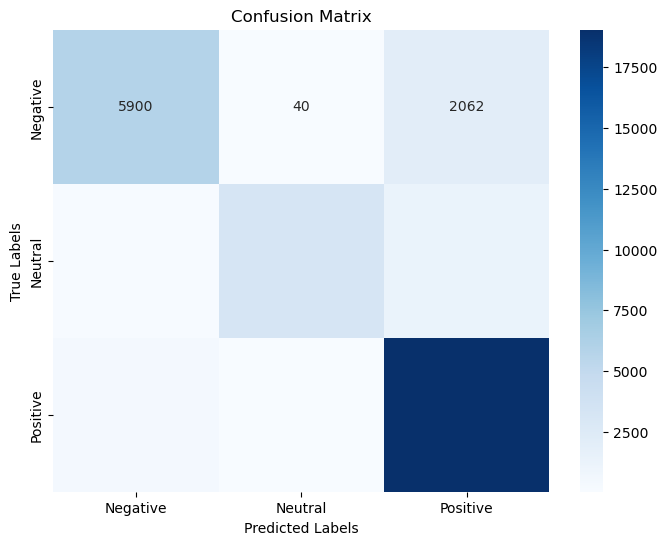


XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.91      0.74      0.81      8002
     Neutral       0.97      0.70      0.81      4720
    Positive       0.85      0.97      0.91     19538

    accuracy                           0.87     32260
   macro avg       0.91      0.80      0.84     32260
weighted avg       0.88      0.87      0.87     32260



<Figure size 800x600 with 0 Axes>

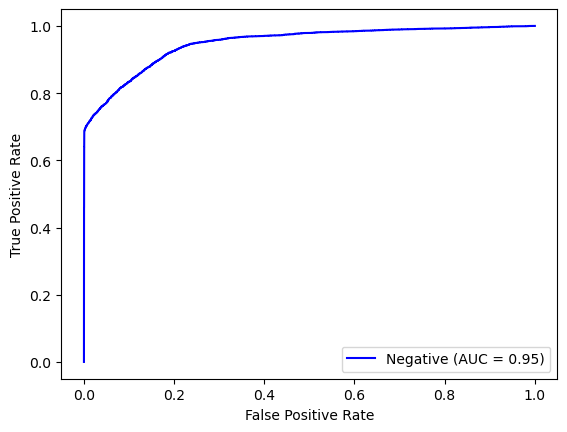

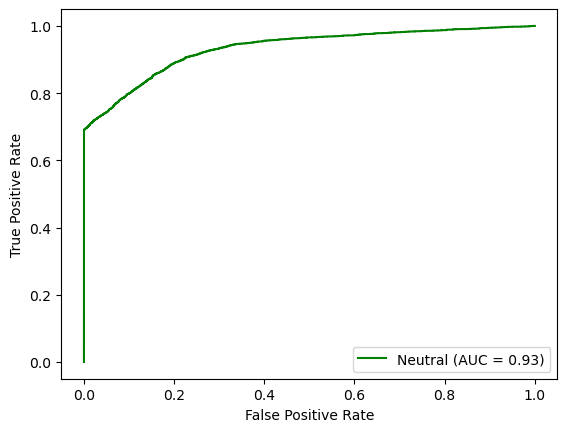

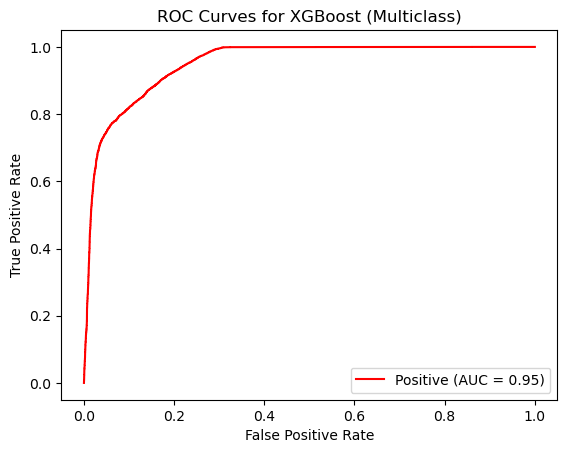

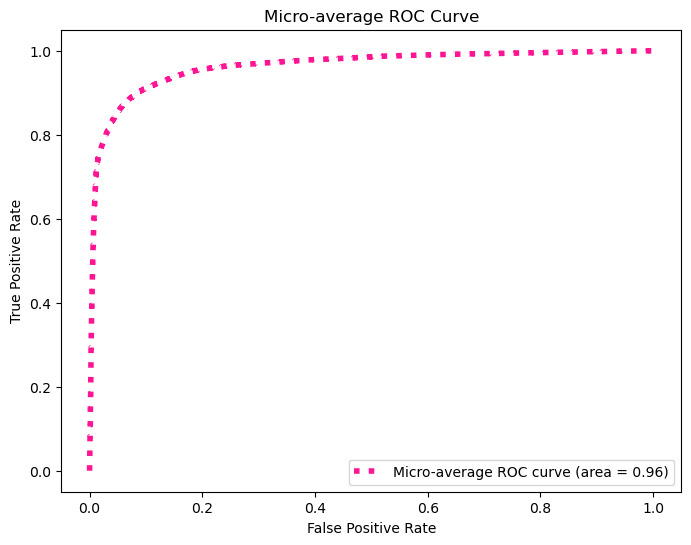

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Assuming target variable 'yw2v_test' has three classes: Negative (0), Neutral (1), Positive (2)
classes = ['Negative', 'Neutral', 'Positive']

# Confusion Matrix
cm = confusion_matrix(yw2v_test, xgb_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("\nXGBoost Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=classes))

# ROC and AUC for Multiclass Classification
# Convert labels to one-hot encoding for ROC curves
yw2v_test_binarized = label_binarize(yw2v_test, classes=[0, 1, 2])
n_classes = yw2v_test_binarized.shape[1]

# Calculate probabilities for the test set
xgb_prob = xgb_classifier.predict_proba(X_test_reduced)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yw2v_test_binarized[:, i], xgb_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=classes[i]).plot(color=color)

plt.title('ROC Curves for XGBoost (Multiclass)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(yw2v_test_binarized.ravel(), xgb_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-average ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro),
         color='deeppink', linestyle=':', linewidth=4)

plt.title('Micro-average ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Monitoring Learning curves for the XGBoost Model

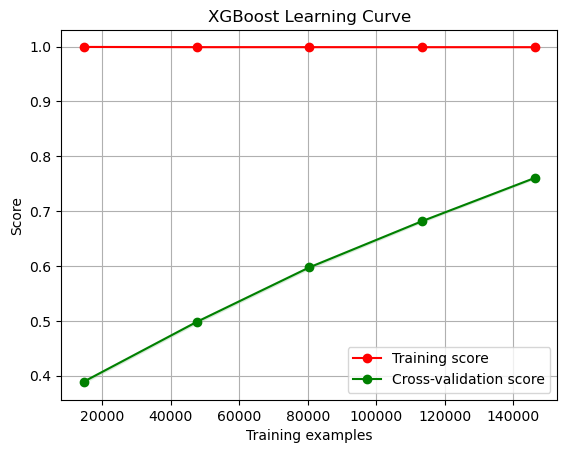

In [58]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(xgb_classifier, "XGBoost Learning Curve", X_train_reduced, yw2v_train, cv=5)
plt.savefig('Learning Curves.png')
plt.show()